## Preprocessing

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from modules.dataset import Dataset, LABELS

In [2]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [3]:
# Constant variables
# NAME = "ResNet50"
EPOCHS = 100
NUM_FOLDS = 5

dataset = Dataset()
fold_num = 3

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Get y_true
y_true = get_y_true(test_dataset)

# Modeling
model = tf.keras.models.load_model("results/models/Resnet50_imagenet_fold_{}.h5".format(fold_num))

2022-11-01 16:27:58.516245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 16:28:00.312254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31965 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [4]:
y_preds = model.predict(test_dataset)

2022-11-01 16:28:22.602676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-01 16:28:23.880109: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-01 16:28:23.881405: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-01 16:28:23.881460: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-01 16:28:23.882573: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-01 16:28:23.882687: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


      7/Unknown - 8s 28ms/step

2022-11-01 16:28:27.329431: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1402/1402 [==============================] - 45s 26ms/step


In [5]:
y_preds

array([[3.7654319e-01, 2.7730334e-01, 6.8009451e-02, ..., 4.3640442e-02,
        4.7264334e-02, 5.1516350e-03],
       [7.5111812e-01, 2.1890929e-02, 1.2101520e-02, ..., 5.6873720e-02,
        3.9397076e-02, 1.1471201e-03],
       [3.9125535e-01, 2.0681956e-01, 9.3845010e-02, ..., 2.9770061e-02,
        2.5005016e-02, 1.9300294e-03],
       ...,
       [9.1306108e-01, 1.3341734e-02, 1.7368582e-03, ..., 3.1054115e-02,
        1.4080364e-02, 6.0132478e-04],
       [7.3586136e-01, 8.7271139e-02, 1.2564676e-02, ..., 2.9964143e-02,
        1.6199512e-02, 3.5609568e-03],
       [6.7980415e-01, 1.6363415e-01, 2.3266707e-02, ..., 5.6244396e-02,
        5.4226551e-02, 6.1115213e-03]], dtype=float32)

In [6]:
m = tf.keras.metrics.AUC(multi_label=True, num_thresholds=200)
m.update_state(y_true, y_preds)
m.result().numpy()

0.7430504

## Our Utils

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from modules.dataset import LABELS

sns.set()

In [12]:
def plot_compare_split(dictionary, name, x_label, y_label):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(name, fontsize=30)
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)

        plt.subplot(3, 5, i+1)
        plt.plot(x, y, marker='.', label=label)

        plt.title(label)
        plt.xlabel(x_label, fontweight='bold')
        plt.ylabel(y_label, fontweight='bold')
        plt.ylim(-0.05, 1.05)
        plt.xlim(-0.05, 1.05)
    plt.show()

In [13]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()

## F1 vs. thresholds

In [14]:
thresholds = m._thresholds

f1_thresholds_dict = dict()
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

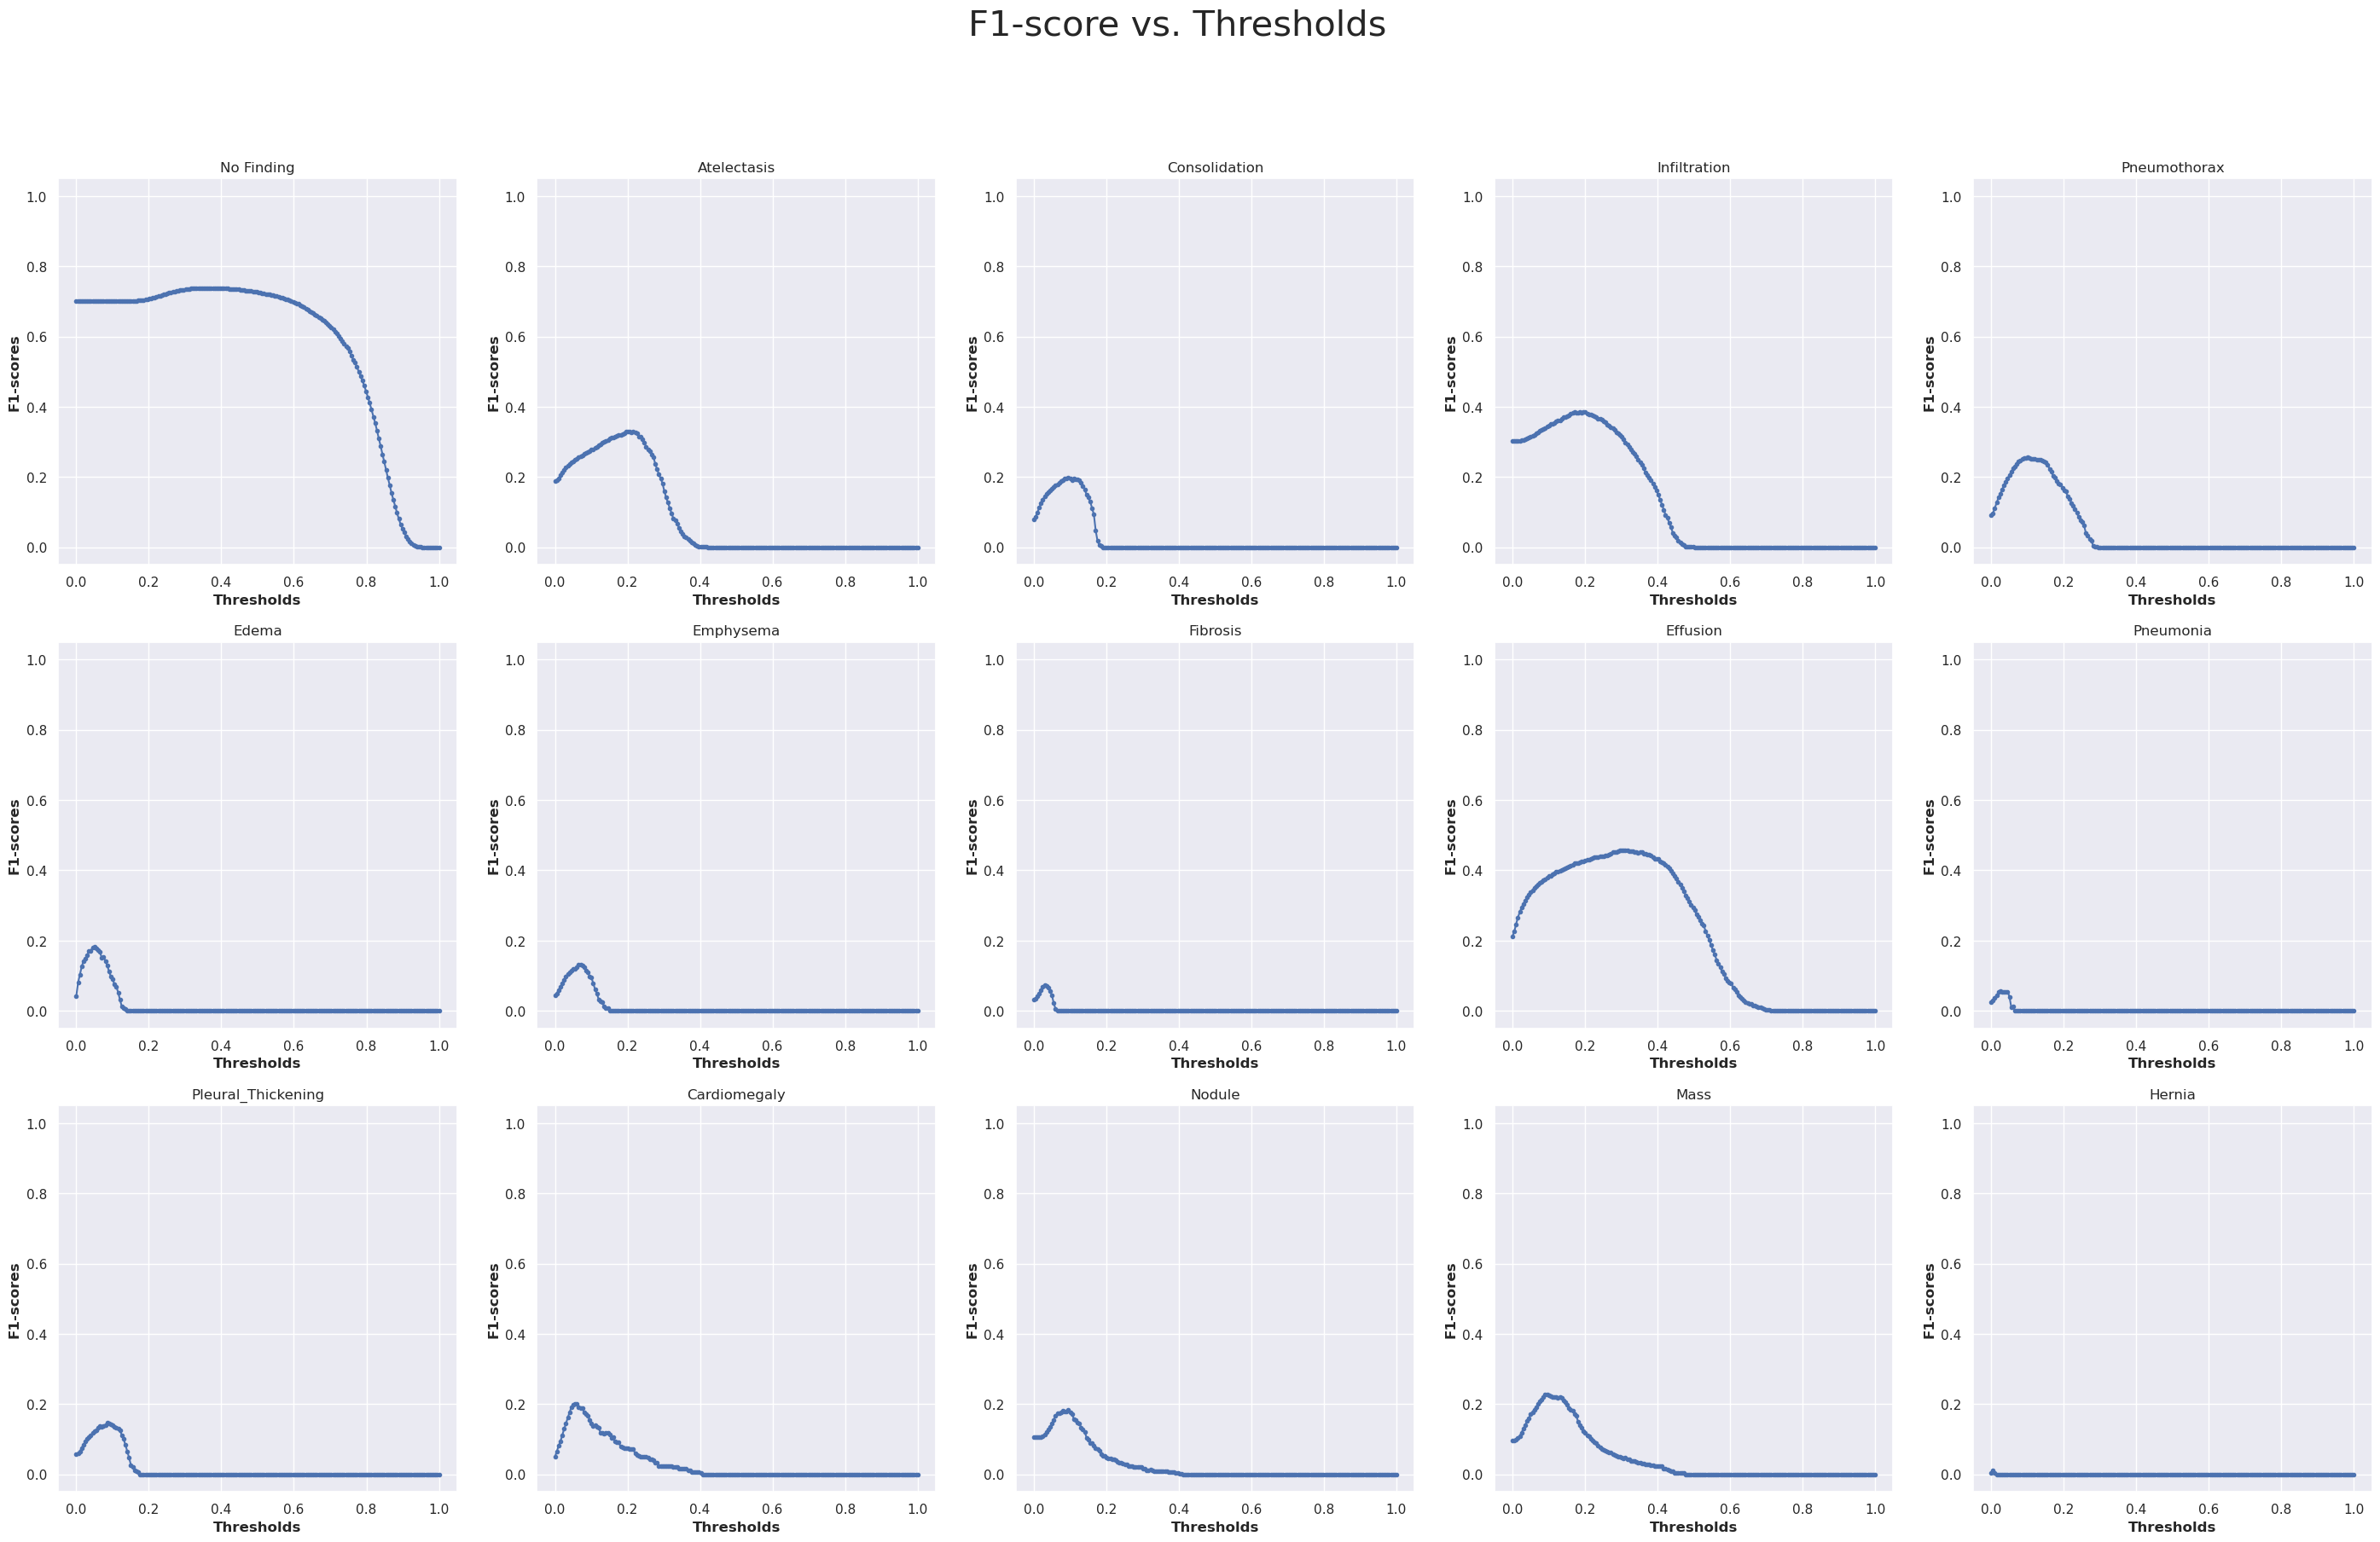

In [15]:
plot_compare_split(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

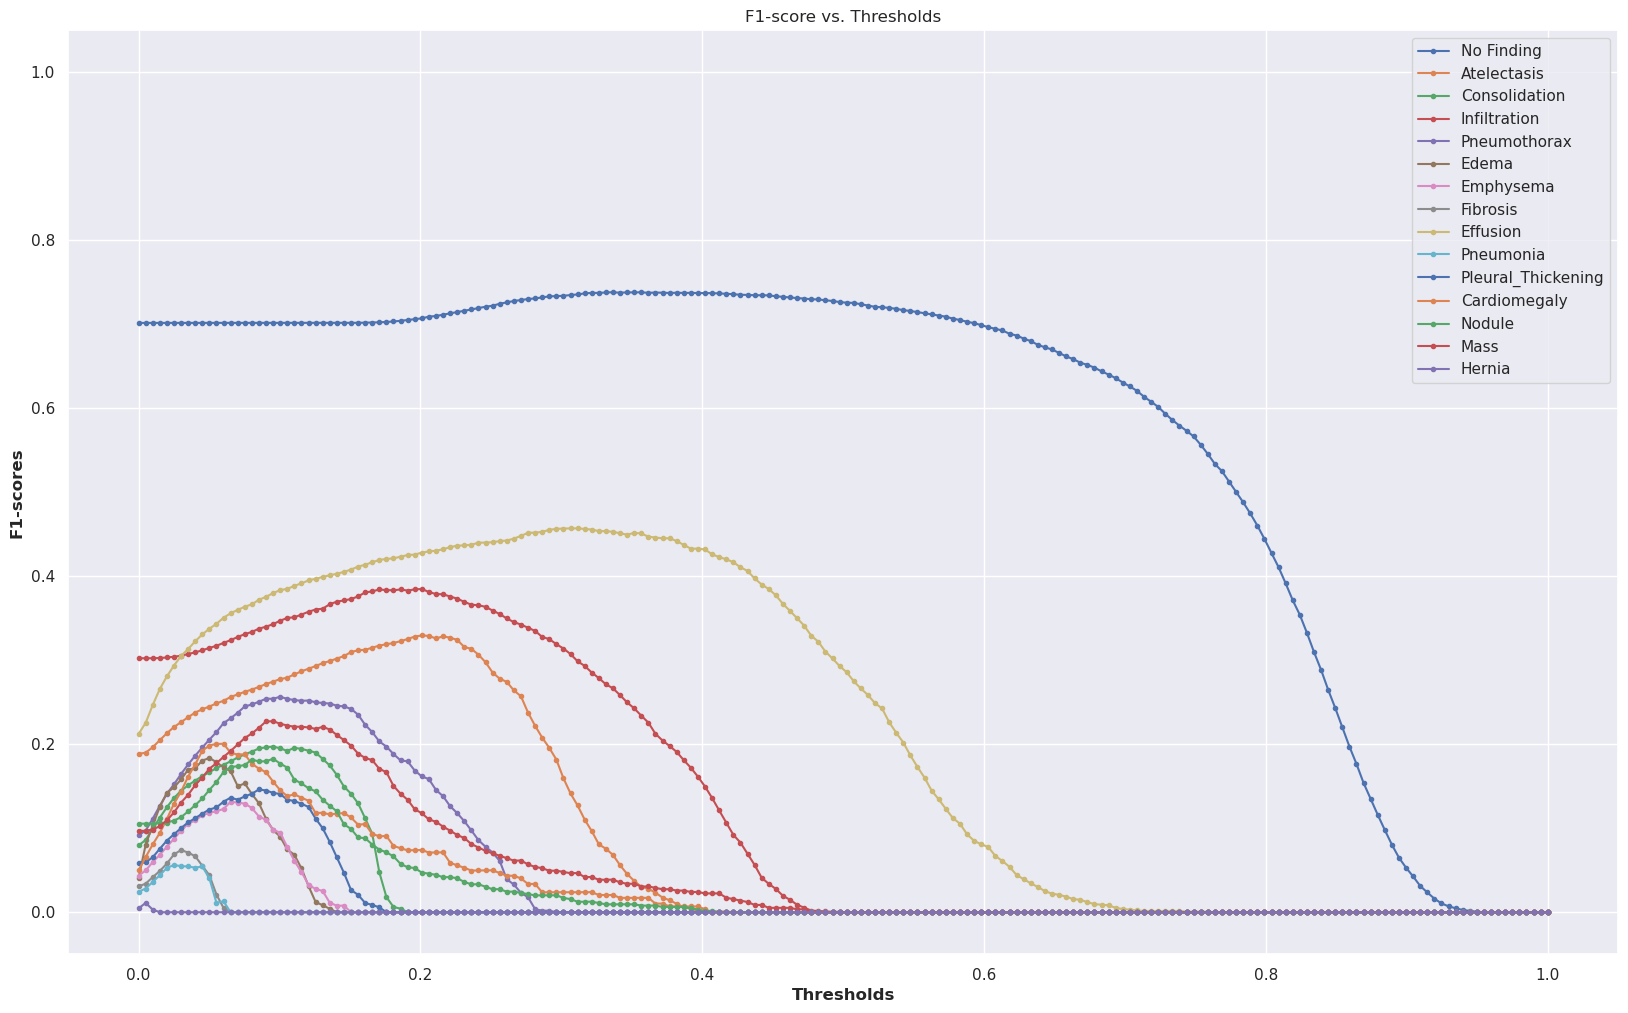

In [16]:
plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

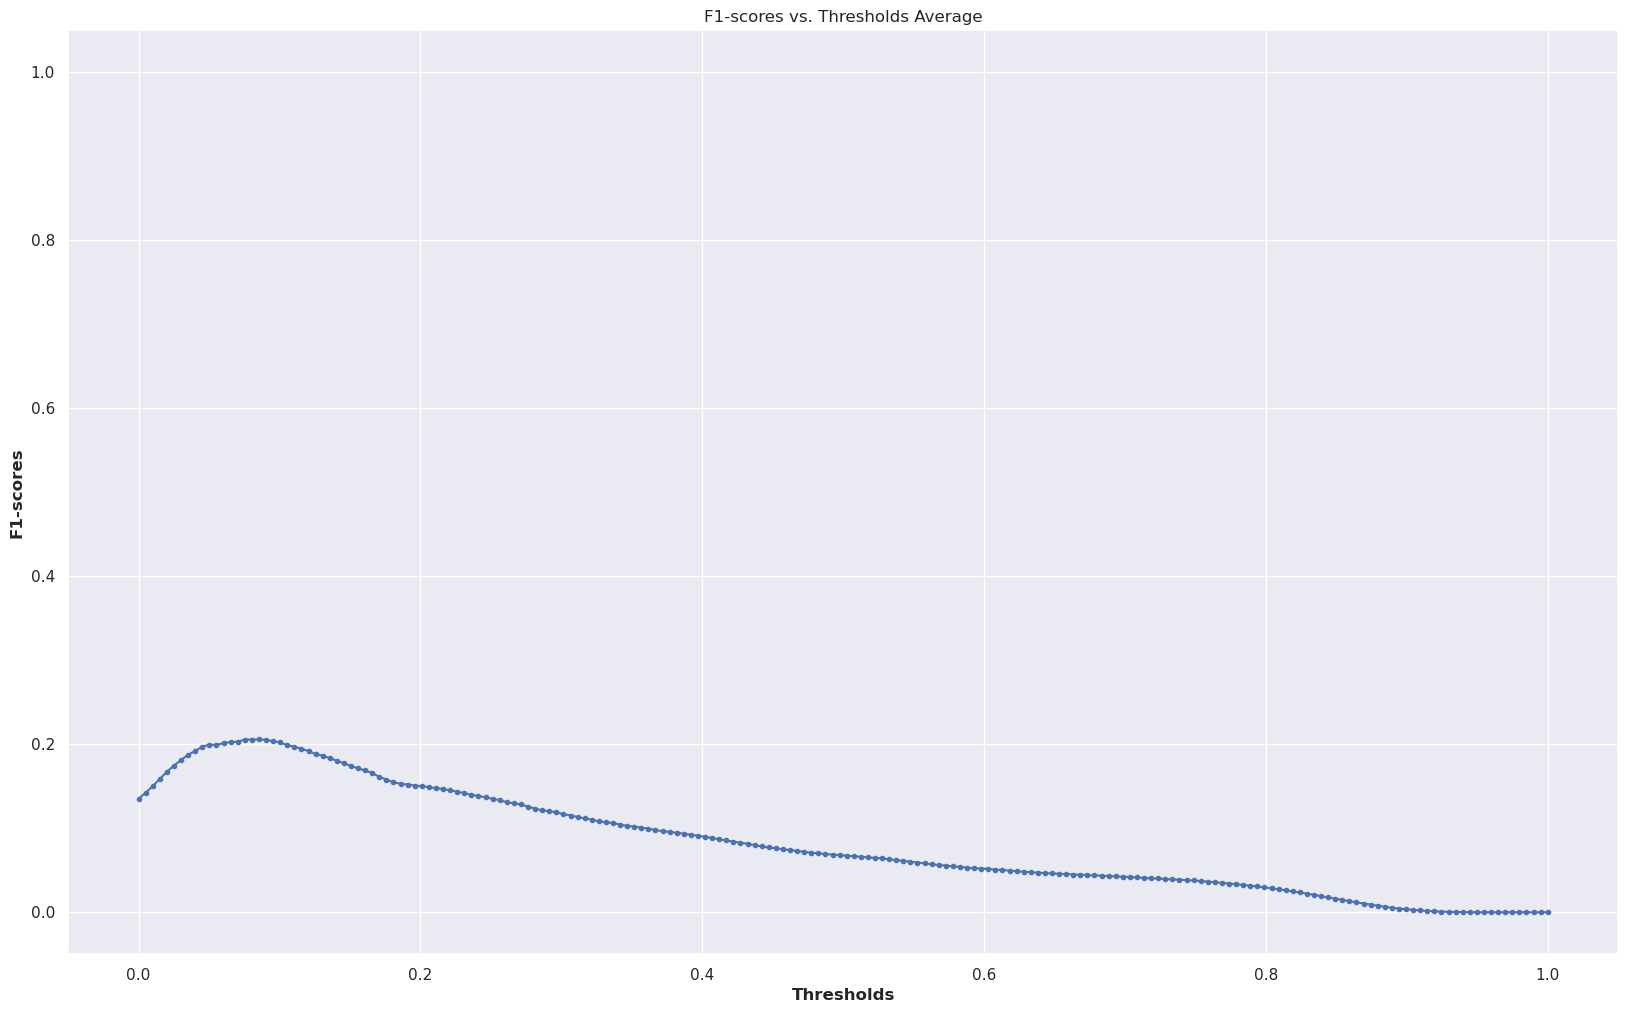

In [17]:
import numpy as np

thresholds = m._thresholds

f1_thresholds_average_list = []
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    f1_score_average = []
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        f1_score = 2*tp / (2*tp + fp + fn)
        f1_score_average.append(f1_score)
        
    f1_score_average = np.mean(f1_score_average)
    f1_thresholds_average_list.append((thresholds[i_thresh], f1_score_average))

# Cast to numpy for vectorlize
f1_thresholds_average_list = np.array(f1_thresholds_average_list)

plt.figure(figsize=(20,12))
plt.plot(f1_thresholds_average_list[:, 0], f1_thresholds_average_list[:, 1], marker='.')
plt.title("F1-scores vs. Thresholds Average")
plt.xlabel("Thresholds", fontweight='bold')
plt.ylabel("F1-scores", fontweight='bold')
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.show()

In [18]:
best_f1_arg = f1_thresholds_average_list.argmax(axis=0)[1]
f1_thresholds_average_list[best_f1_arg]

array([0.08542714, 0.205685  ])

## AUC

In [15]:
thresholds = m._thresholds
thresholds[:5]

array([-1.00000000e-07,  5.02512563e-03,  1.00502513e-02,  1.50753769e-02,
        2.01005025e-02])

In [16]:
threshold = 4
(y_preds > thresholds[threshold]).astype('int16')

array([[1, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0]], dtype=int16)

In [17]:
roc_dict = dict()
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        try: 
            roc_dict[label].append((tpr, fpr))
        except:
            roc_dict[label] = [(tpr, fpr)]

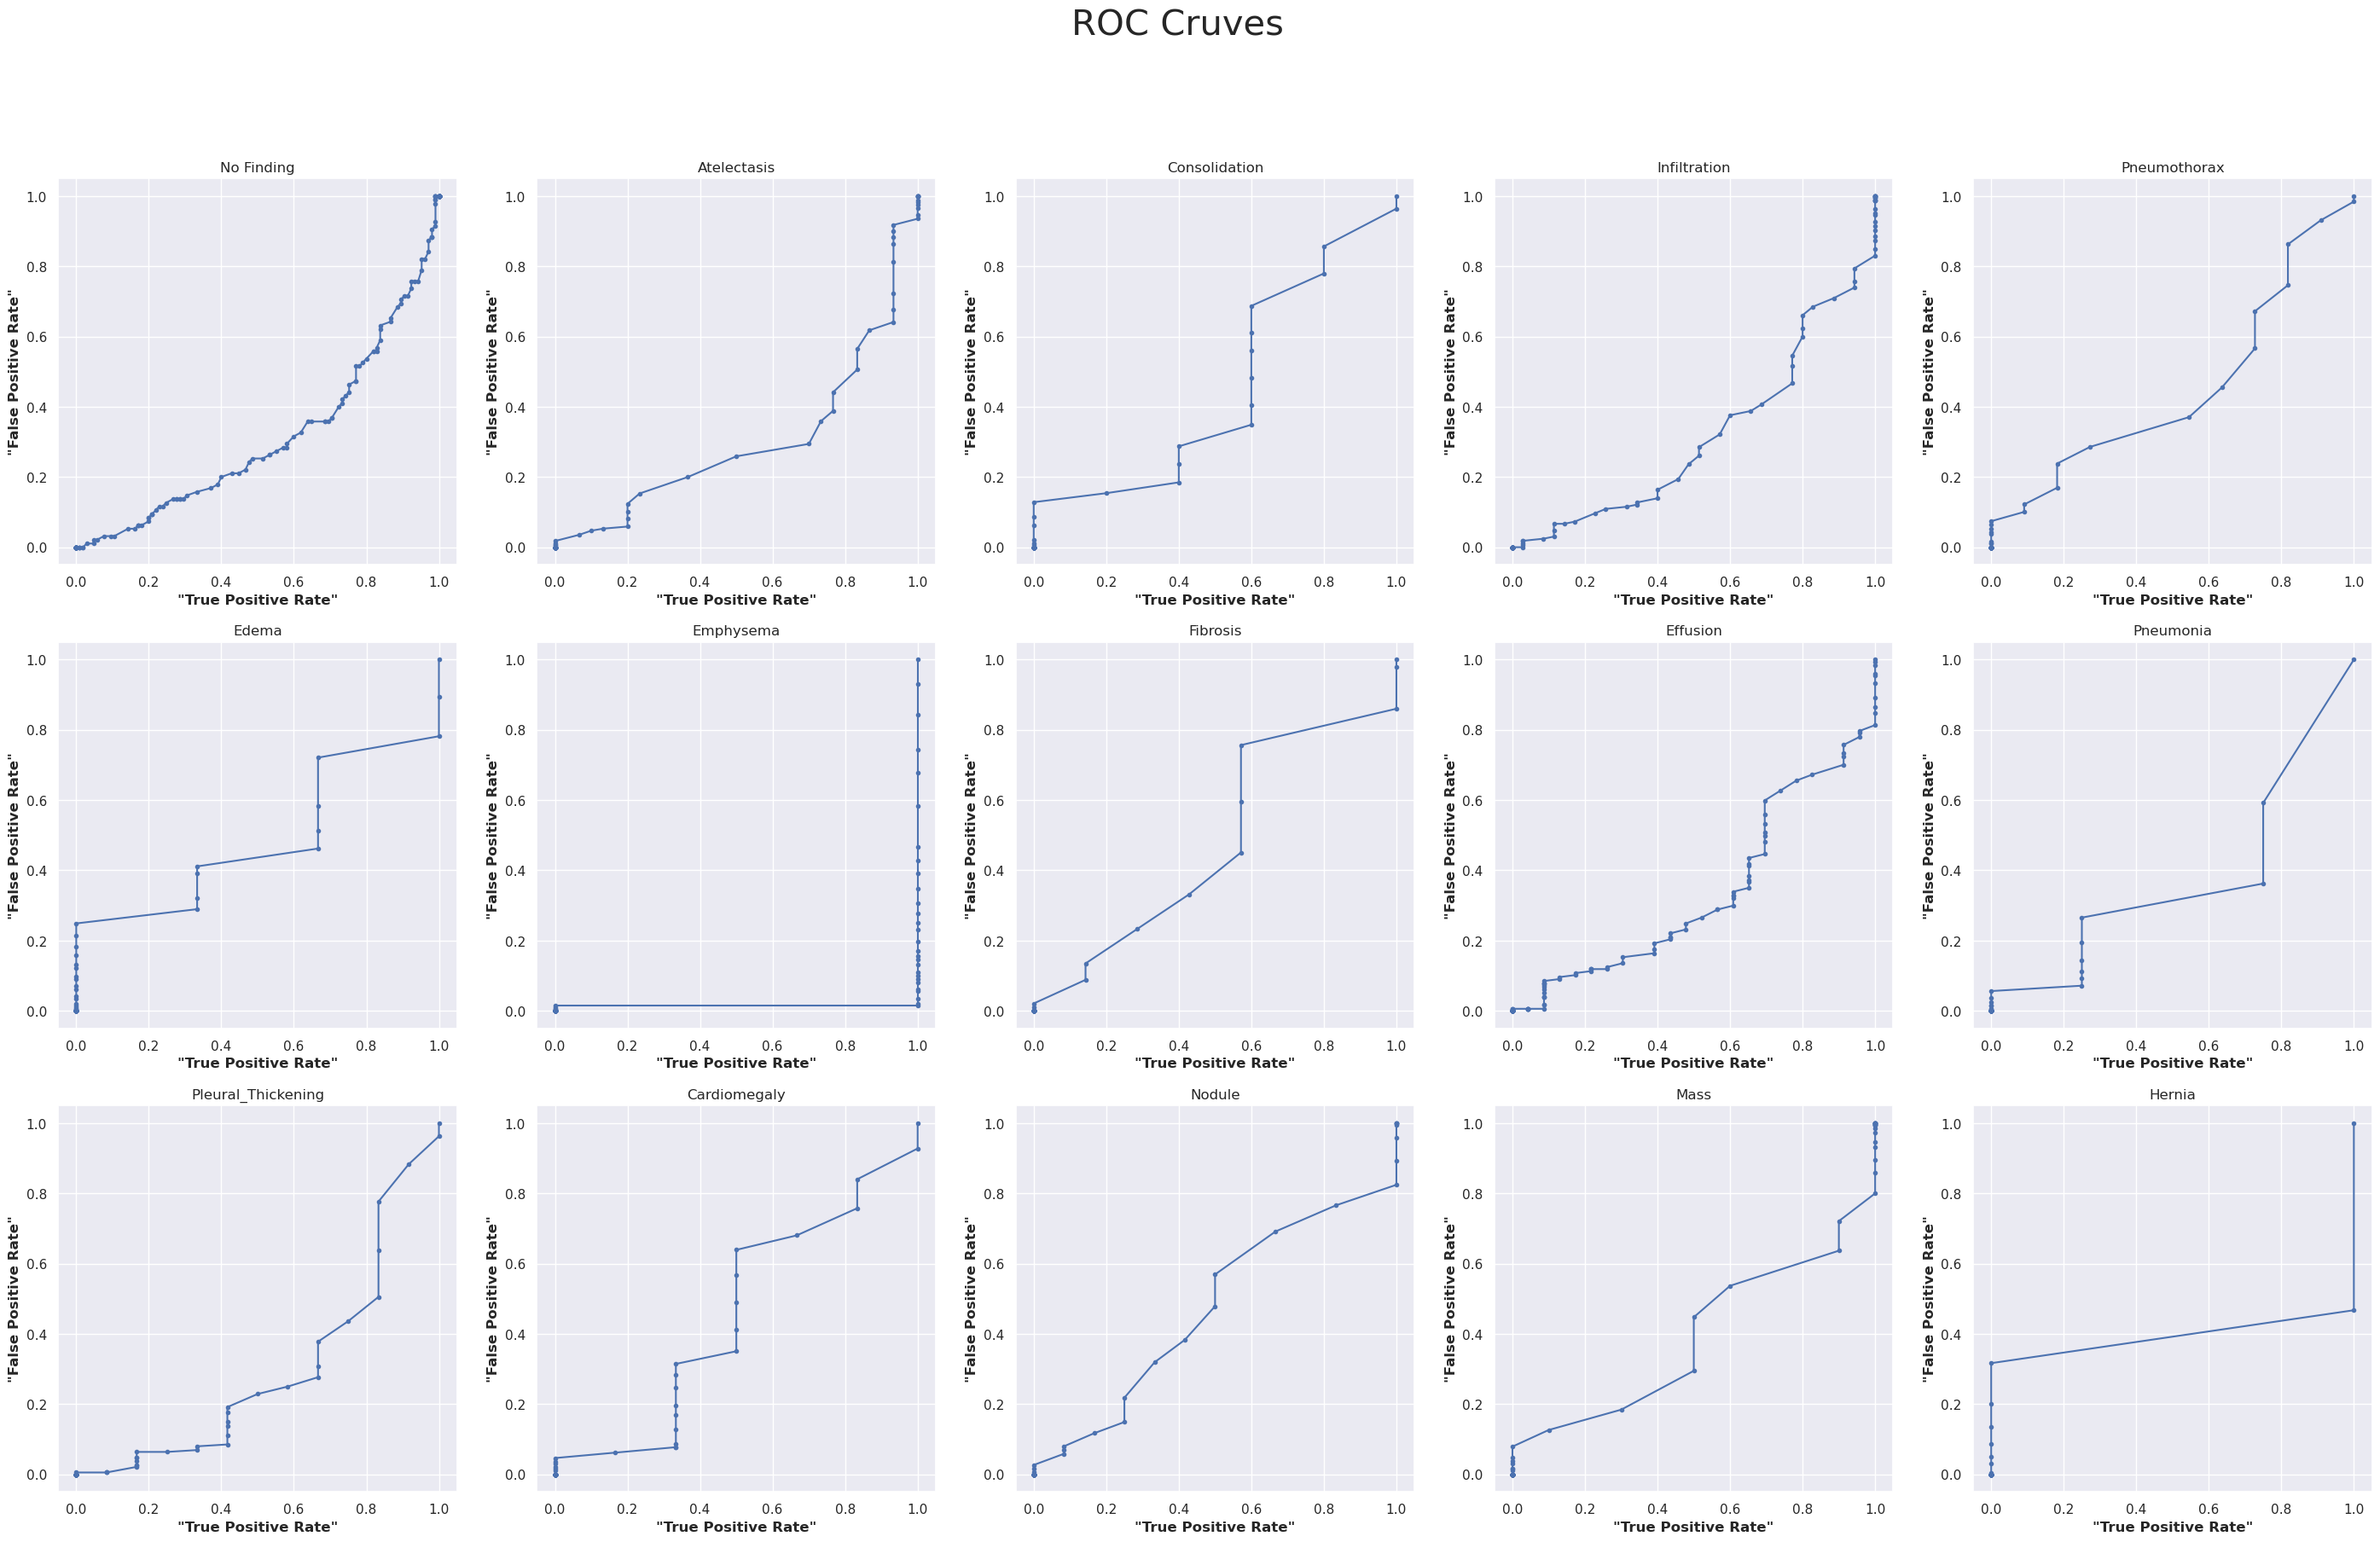

In [18]:
plot_compare_split(roc_dict, name="ROC Cruves", x_label='"True Positive Rate"', y_label='"False Positive Rate"')

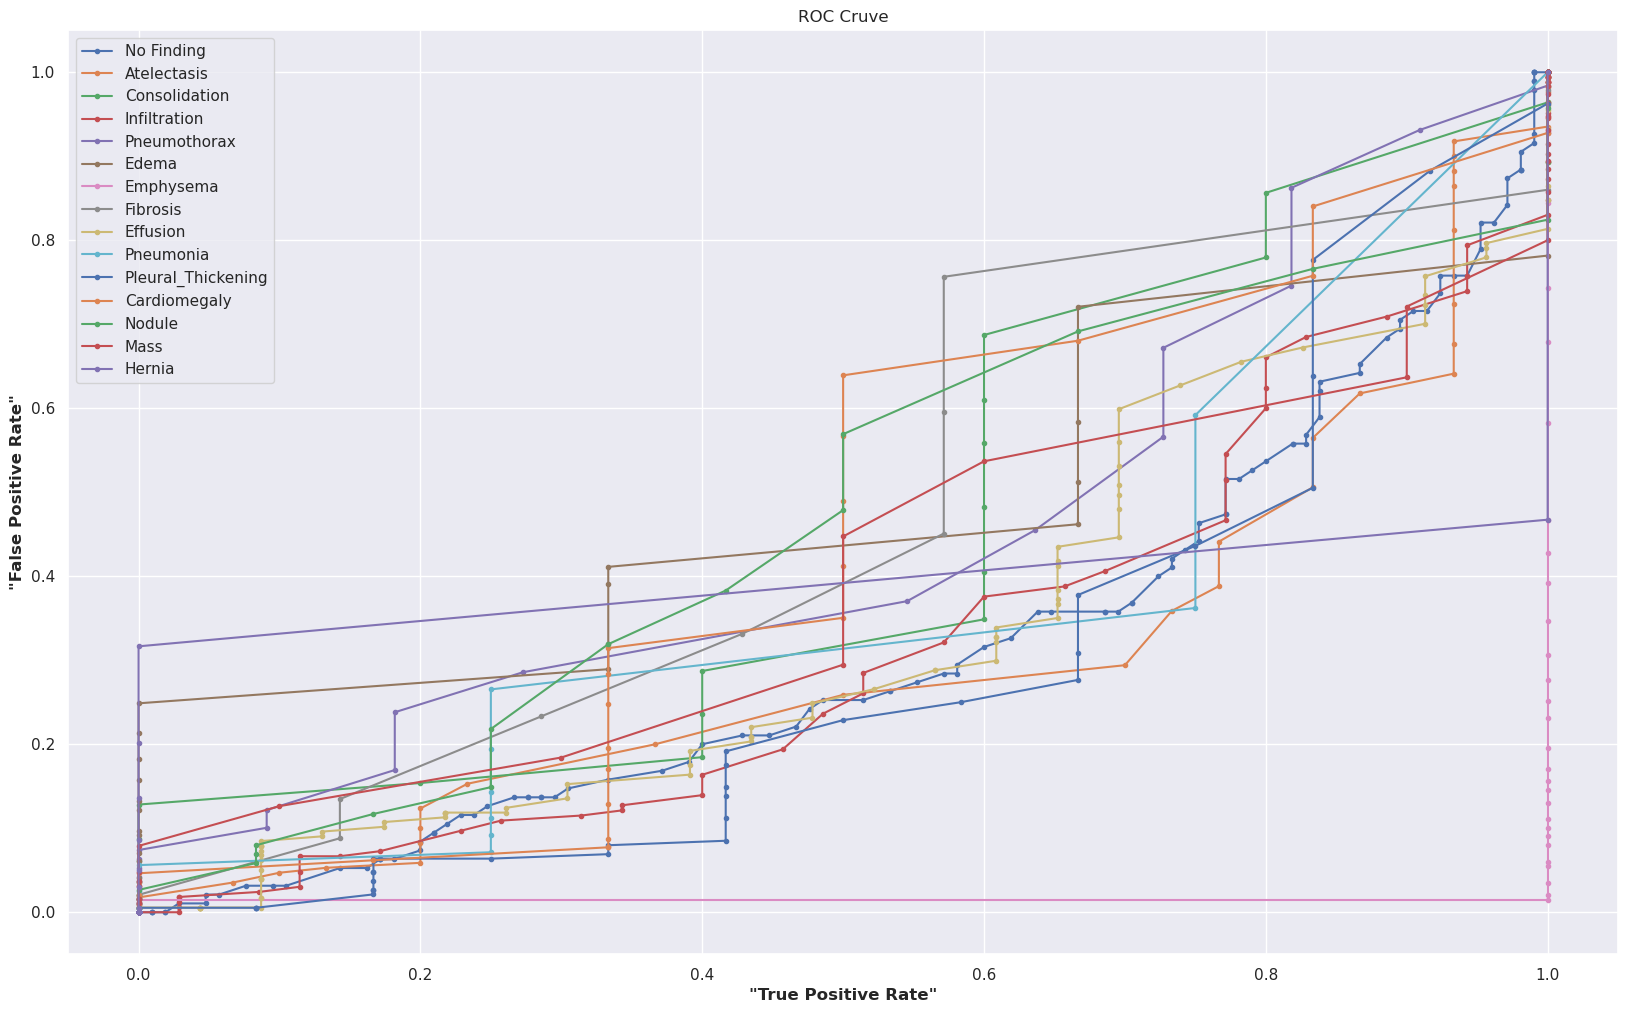

In [19]:
plot_compare(roc_dict, name="ROC Cruve", x_label='"True Positive Rate"', y_label='"False Positive Rate"')

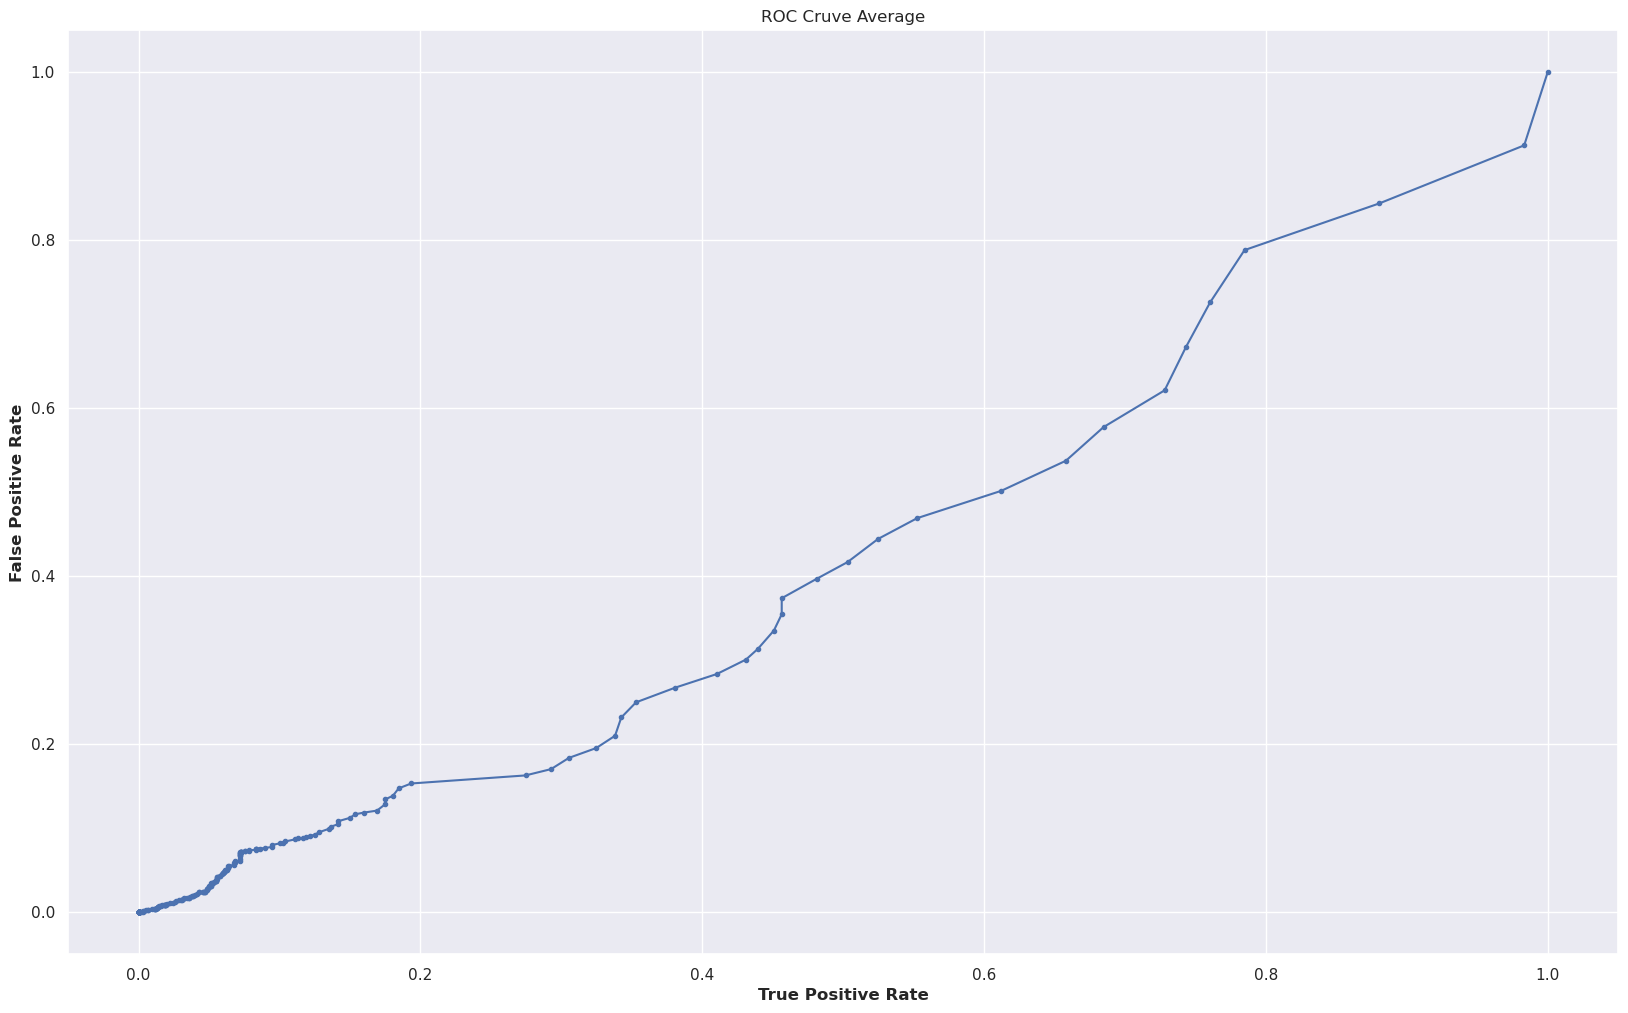

In [21]:
import numpy as np

roc_average_list = []
true_positives, true_negatives, false_positives, false_negatives = m.variables
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(true_positives, true_negatives, false_positives, false_negatives)):
    tpr_list = []
    fpr_list = []
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        tp, tn, fp, fn = tp.numpy(), tn.numpy(), fp.numpy(), fn.numpy()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_average = np.mean(tpr_list)
    fpr_average = np.mean(fpr_list)
    roc_average_list.append((thresholds[i_thresh], tpr_average, fpr_average))

# Cast to numpy for vectorlize
roc_average_list = np.array(roc_average_list)

plt.figure(figsize=(20,12))
plt.plot(roc_average_list[:, 1], roc_average_list[:, 2], marker='.')
plt.title("ROC Cruve Average")
plt.xlabel("True Positive Rate", fontweight='bold')
plt.ylabel("False Positive Rate", fontweight='bold')
plt.show()

## Confusion Metrics

In [ ]:
!pip install tensorflow_addons

In [19]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('"Prediction"', fontweight='bold')
        plt.ylabel('"Actual"', fontweight='bold')

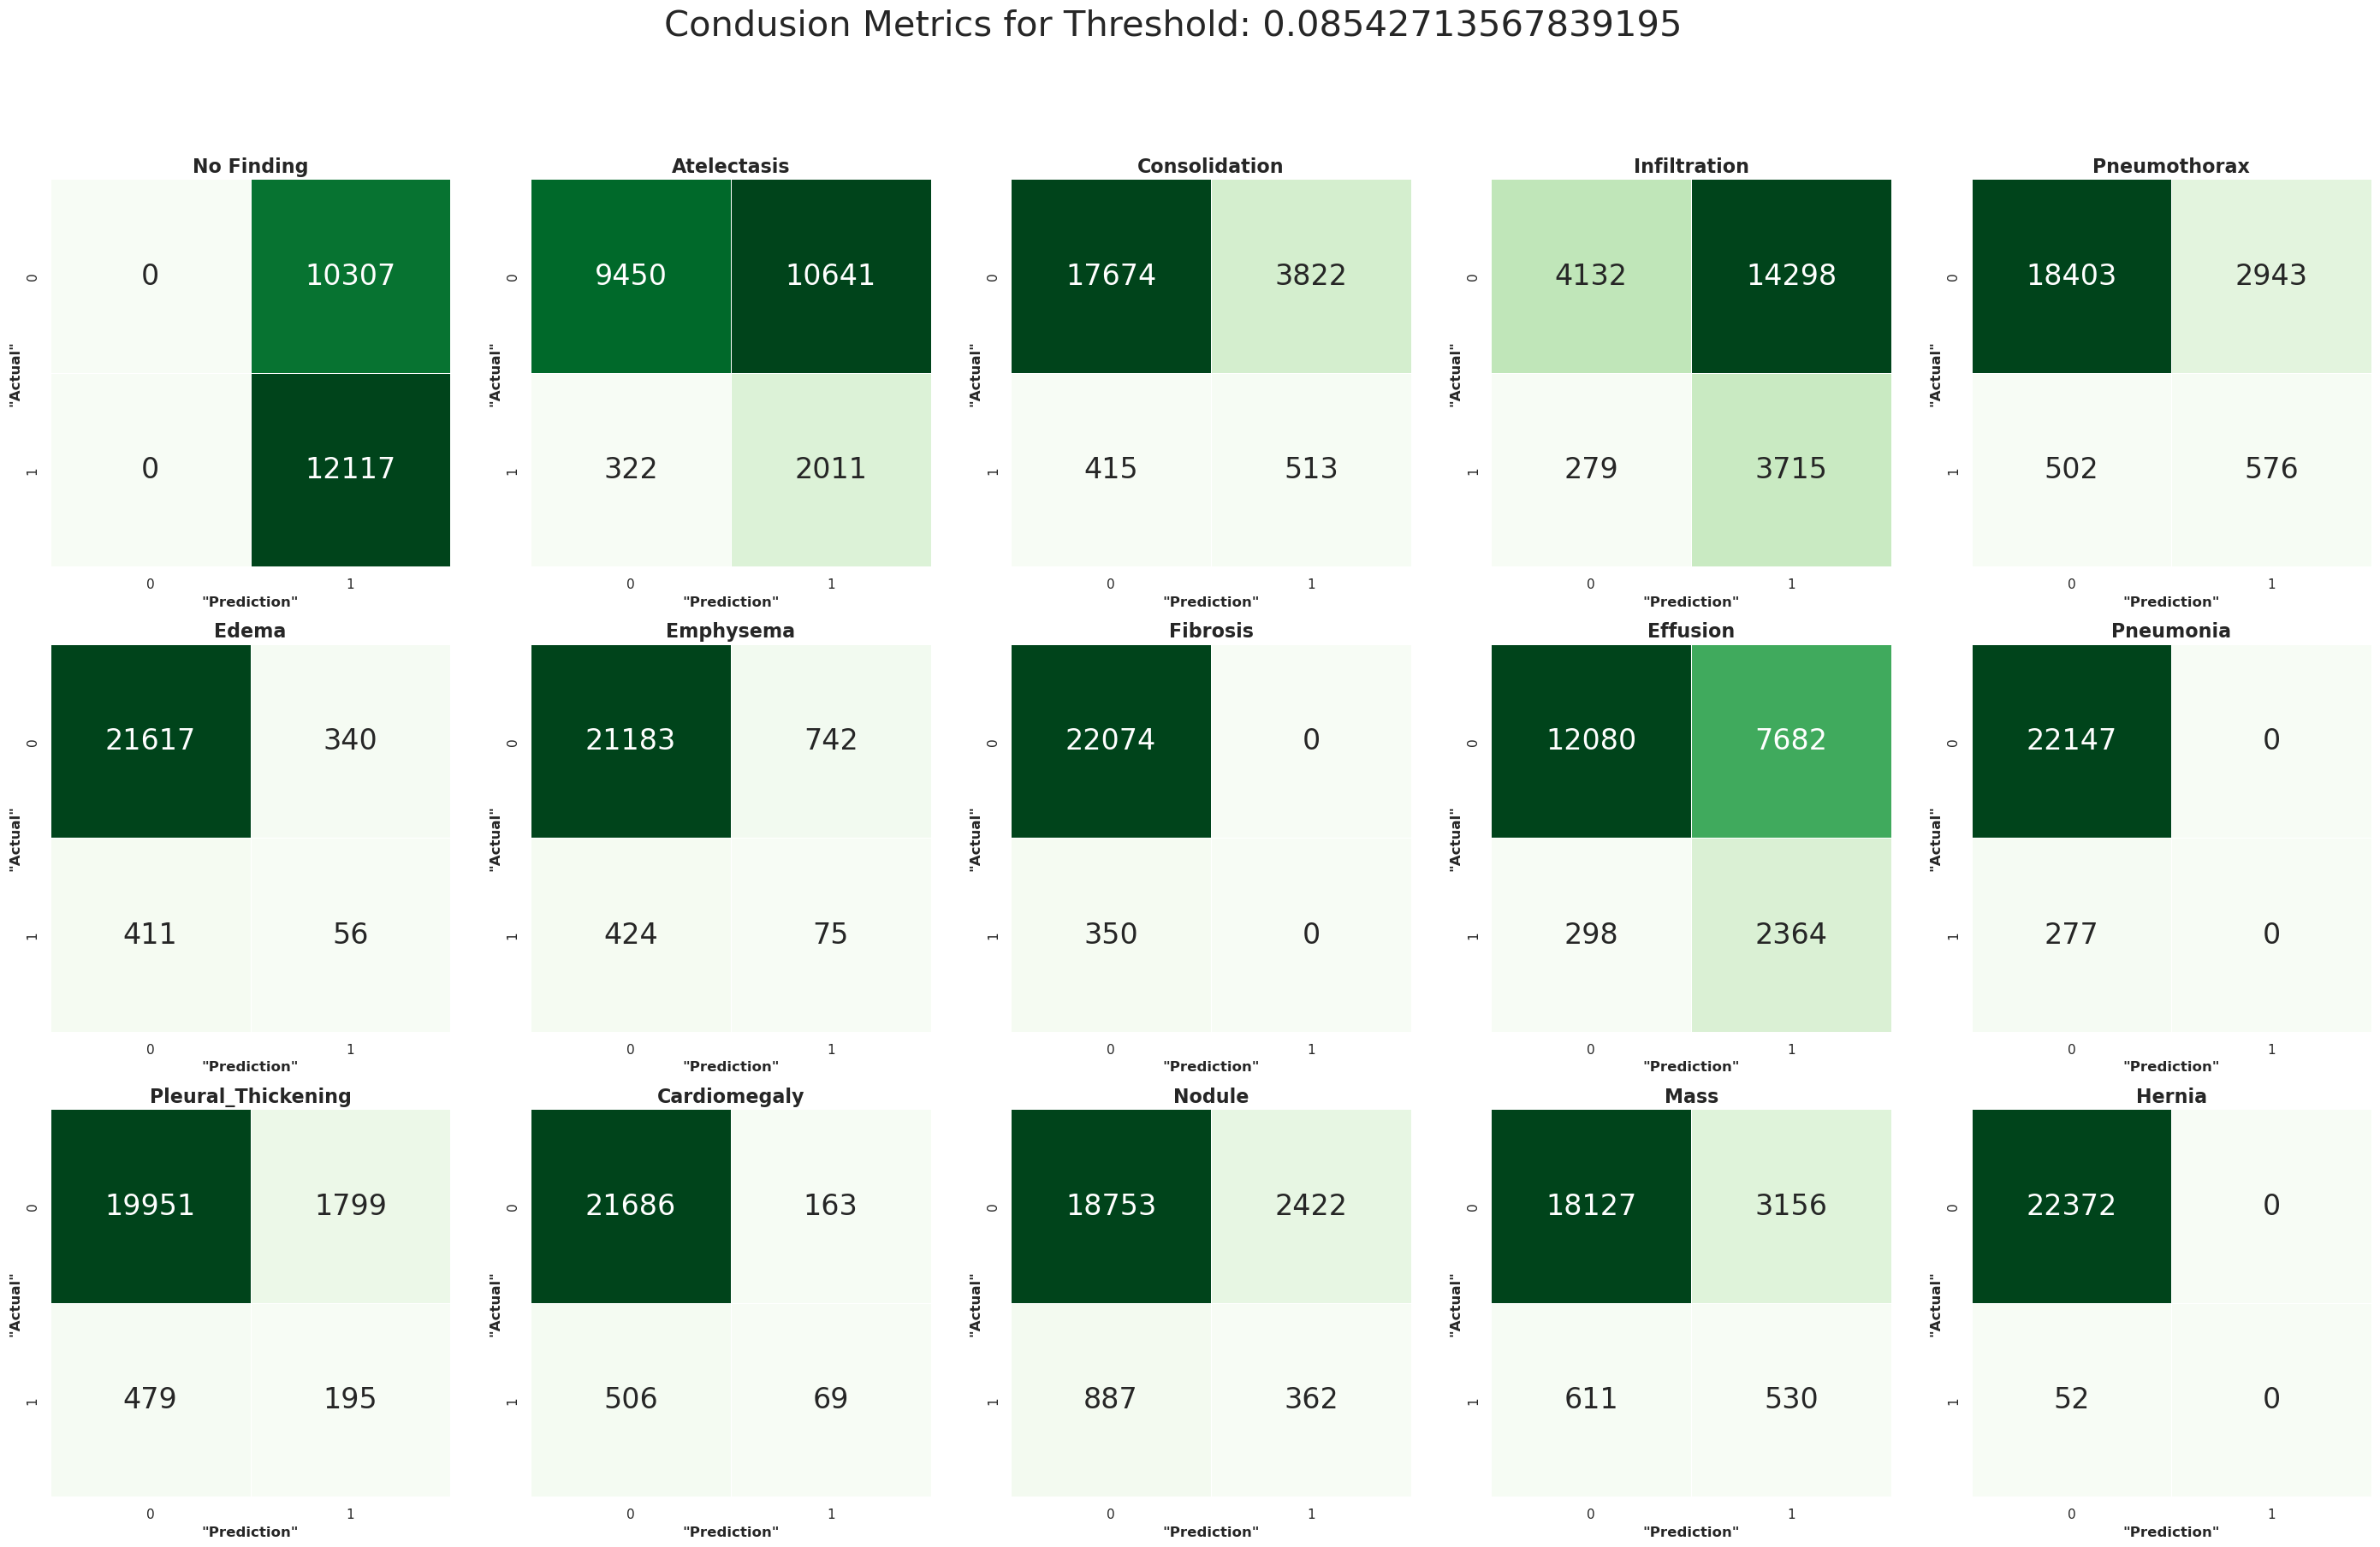

In [20]:
import numpy as np
import tensorflow_addons as tfa

for thresh_value in thresholds[:2]:
    thresh_value = thresholds[best_f1_arg]
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true, 
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()
    break